In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

import key_rate_optimization as opt
from importlib import reload
reload(opt)

<module 'key_rate_optimization' from '/Users/gordonwongyl/Documents/ORF/Reproduce_result/key_rate_optimization.py'>

In [21]:
df = pd.read_csv("opt_record_1000e3_2D.csv")
routines = ["<class 'key_rate_optimization.tgs_a_routine'>", "<class 'key_rate_optimization.tgs_f_routine'>", 
            "<class 'key_rate_optimization.rgs_a_routine'>", "<class 'key_rate_optimization.rgs_f_routine'>"]

# Divide optimization record based on the scheme used
df_list = []
for rout in routines:
    df_rout = df[df["rout"] == rout]
    df_rout.sort_values(by=["T_SPIN_COHERENCE", "GAMMA"], ascending=[True, True])
    df_list.append(df_rout)
df = df.sort_values(by=["rout", "T_SPIN_COHERENCE", "GAMMA"], ascending=[True, True, True])
df.to_csv("opt_record_1000e3_2D_sort")

In [22]:
GAMMA = 10**np.arange(7,16)*2*np.pi
T_SPIN_COHERENCE = 10.**np.arange(-7,4)
xx, yy = np.meshgrid(T_SPIN_COHERENCE, GAMMA/2/np.pi)

# Construct a 2D matrix of fitness values, with 
heat_map_list = []
for df in df_list:
    heat_map = np.zeros((len(GAMMA), len(T_SPIN_COHERENCE)))
    for i in range(len(GAMMA)):
        for j in range(len(T_SPIN_COHERENCE)):
            heat_map[i,j] = df[(df["GAMMA"] == GAMMA[i]) & 
                               (df["T_SPIN_COHERENCE"] == T_SPIN_COHERENCE[j])]["best_solutions_fitness"]
    heat_map = np.where(heat_map==0, 0.1, heat_map)        
    heat_map_list.append(heat_map)
names = ['tgs_a', 'tgs_f', 'rgs_a', 'rgs_f']
fig, axes = plt.subplots(1,4, figsize=(25,5))
vmin = min([heat_map.min() for heat_map in heat_map_list])
vmin = 1e-1
vmax = 1e6
norm = LogNorm(vmin=vmin, vmax=vmax)
for ax, heat_map, name in zip(axes.reshape(-1), heat_map_list, names):

        im = ax.pcolor(xx, yy, heat_map, norm=norm)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel("$t_{coh}$")
        ax.set_ylabel("gamma/2/pi")
        ax.set_title(name + f" at L={3000} km")
fig.colorbar(im, ax= axes, orientation='vertical')
plt.show()
# fig.savefig('2Dmap_L_3000e3.png', facecolor='white')

ValueError: setting an array element with a sequence.

In [3]:
# Distance plots
df2 = pd.read_csv("opt_record_L_v2.csv")
routines = ["<class 'key_rate_optimization.tgs_a_routine'>", "<class 'key_rate_optimization.tgs_f_routine'>", 
            "<class 'key_rate_optimization.rgs_a_routine'>", "<class 'key_rate_optimization.rgs_f_routine'>"]
df2_list = []
for rout in routines:
    df_rout = df2[df2["rout"] == rout]
    df_rout.sort_values(by=["T_SPIN_COHERENCE", "GAMMA", "L"], ascending=[True, True, True])
    df2_list.append(df_rout)
df2 = df2.sort_values(by=["rout", "T_SPIN_COHERENCE", "GAMMA", "L"], ascending=[True, True, True, True])
# df2.to_csv("opt_record_L__v2_sort.csv")

In [4]:
L_list = np.linspace(1e3,3000e3,20)
GAMMA = np.array([2e9, 100e9, 170e6, 100e9]) * 2 * np.pi
T_SPIN_COHERENCE = [13e-3, 4e-6, 1., 1.]

R_axis = []
for df in df2_list:
    for i in range(20,81,20):
        # print(list(df[i-20:i]["best_solutions_fitness"]))
        R_axis.append(list(df[i-20:i]["best_solutions_fitness"]))

# R = np.zeros(len(L_list))
# df = df2_list[1]
# R[i] = df[(df["T_SPIN_COHERENCE"] == T_SPIN_COHERENCE[1]) & (df["GAMMA"] == GAMMA[1]) & (df["L"] == L_list[5])]["best_solutions_fitness"]

In [5]:
names = ['tgs_a', 'tgs_f', 'rgs_a', 'rgs_f']
R_dict = {}

for name_in in range(4):
    name = names[name_in]
    for param_in in range(4):
        r = R_axis[name_in*4 + param_in]
        R_dict[(name, param_in)] = r 

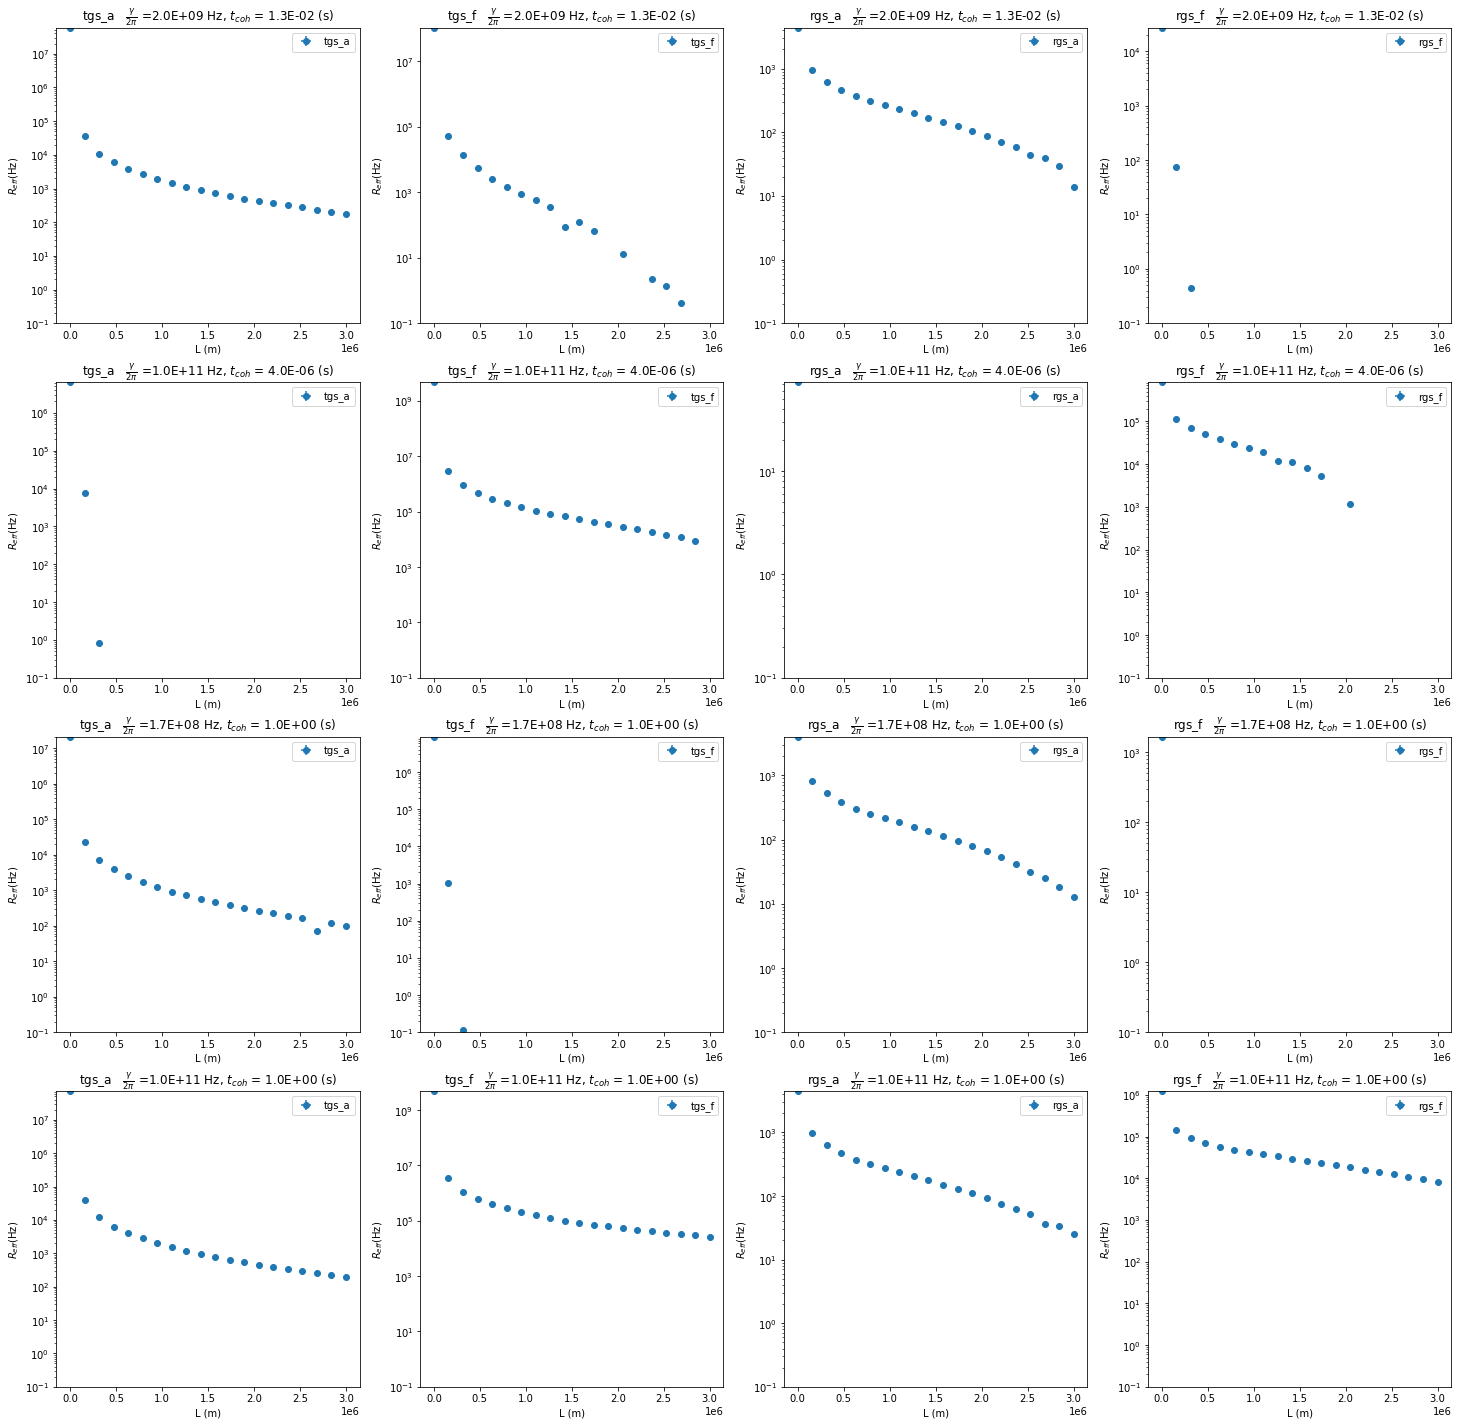

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
names = ['tgs_a', 'tgs_f', 'rgs_a', 'rgs_f']
fig.set_facecolor('white')
for name_in in range(4):
    name = names[name_in]
    for param_in in range(4):
        ax = axes[param_in][name_in]
        r = R_dict[(name, param_in)]
        ax.errorbar(L_list, r, xerr=0, yerr=0, fmt='o', label=name)
        ax.set_yscale('log')
        ax.set_ylabel("$R_{eff}$" + "(Hz)")
        ax.set_xlabel("L (m)")
        ax.set_ylim(0.1,max(r))
        ax.set_title(name + "   " + "$\\frac{\gamma}{2\pi}$ =" + f"{GAMMA[param_in]/2/np.pi :.1E} Hz, " + 
                     "$t_{coh}$ = " f"{T_SPIN_COHERENCE[param_in]:.1E} (s)")
        ax.legend()

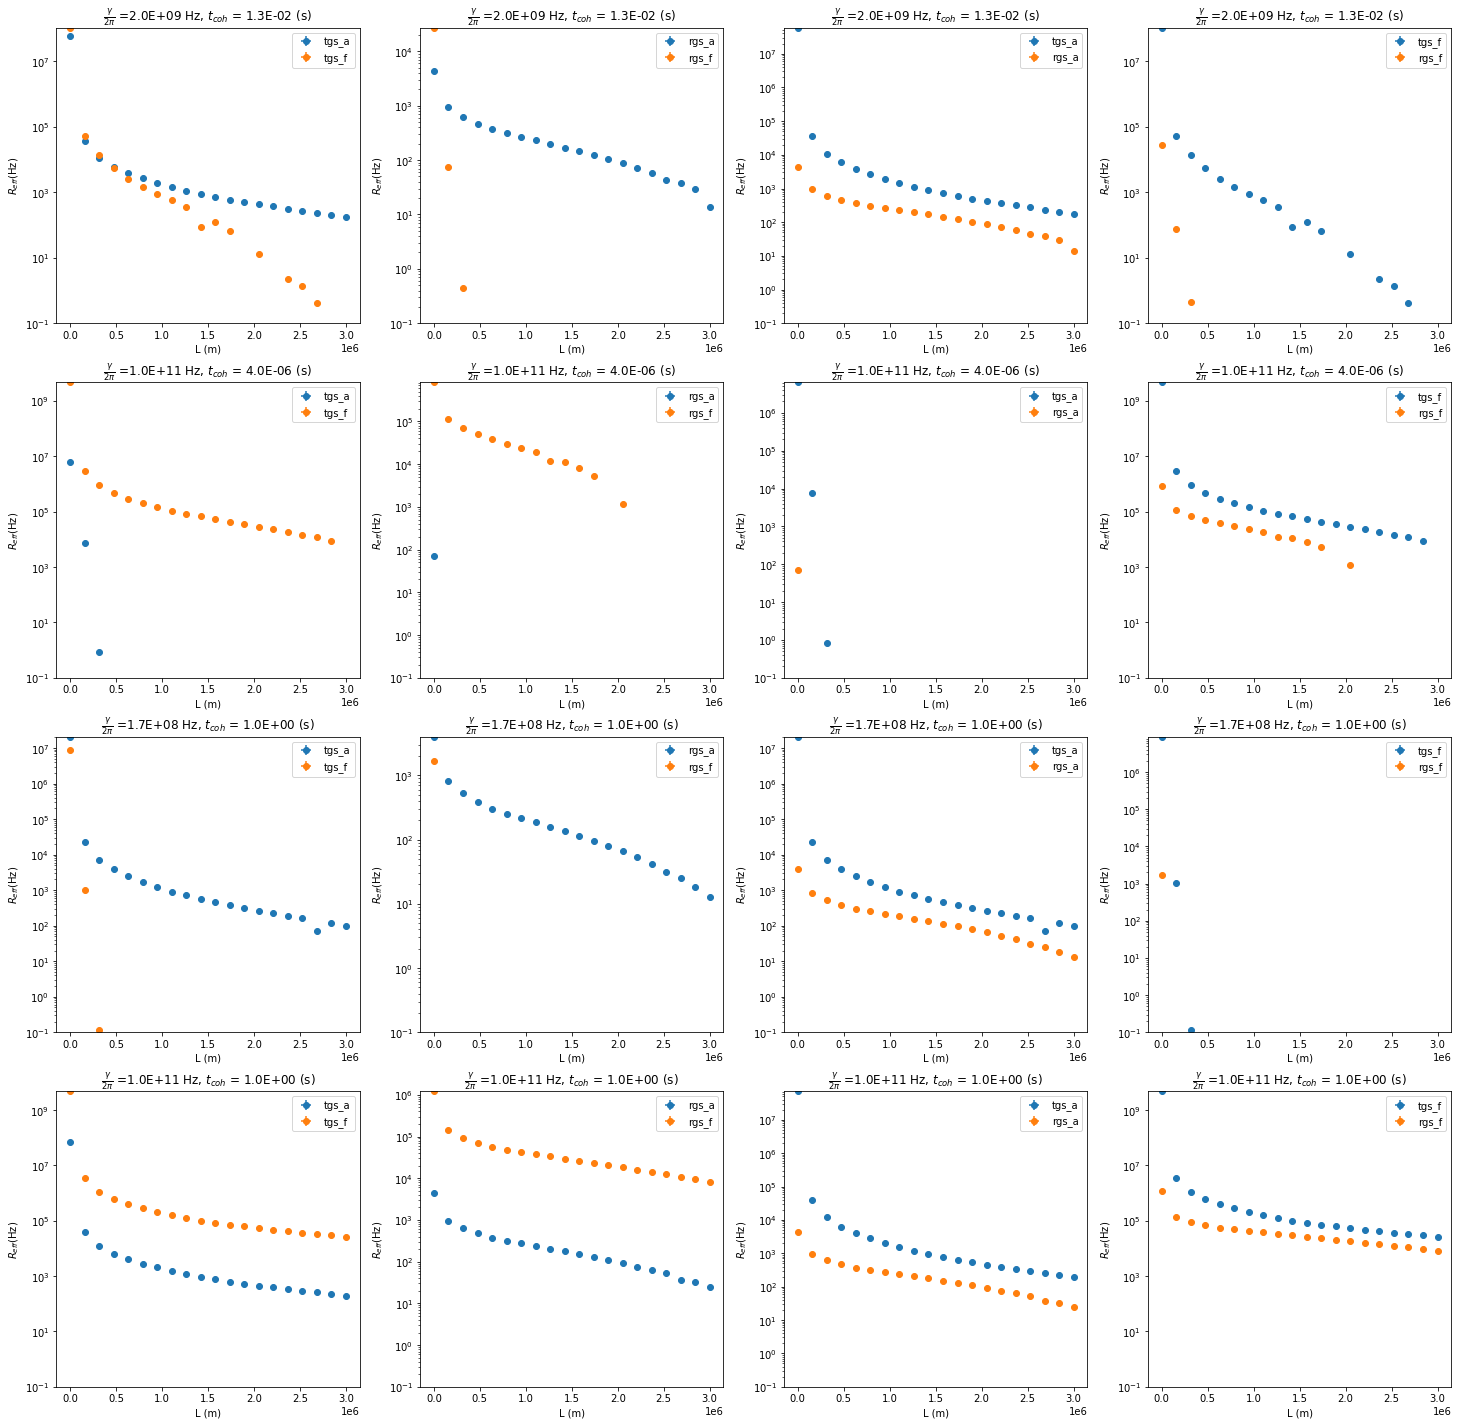

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
comparisons = [('tgs_a', 'tgs_f'), ('rgs_a', 'rgs_f'), ('tgs_a', 'rgs_a'), ('tgs_f', 'rgs_f')]
fig.set_facecolor('white')
for comp_in in range(4):
    comp = comparisons[comp_in]
    for param_in in range(4):
        ax = axes[param_in][comp_in]
        r0 = R_dict[(comp[0], param_in)]
        r1 = R_dict[(comp[1], param_in)]
        ax.errorbar(L_list, r0, xerr=0, yerr=0, fmt='o', label=comp[0])
        ax.errorbar(L_list, r1, xerr=0, yerr=0, fmt='o', label=comp[1])
        ax.set_yscale('log')
        ax.set_ylabel("$R_{eff}$" + "(Hz)")
        ax.set_xlabel("L (m)")
        ax.set_ylim(0.1,max((max(r0), max(r1))))
        ax.set_title("$\\frac{\gamma}{2\pi}$ =" + f"{GAMMA[param_in]/2/np.pi :.1E} Hz, " + 
                     "$t_{coh}$ = " f"{T_SPIN_COHERENCE[param_in]:.1E} (s)")
        ax.legend()
        

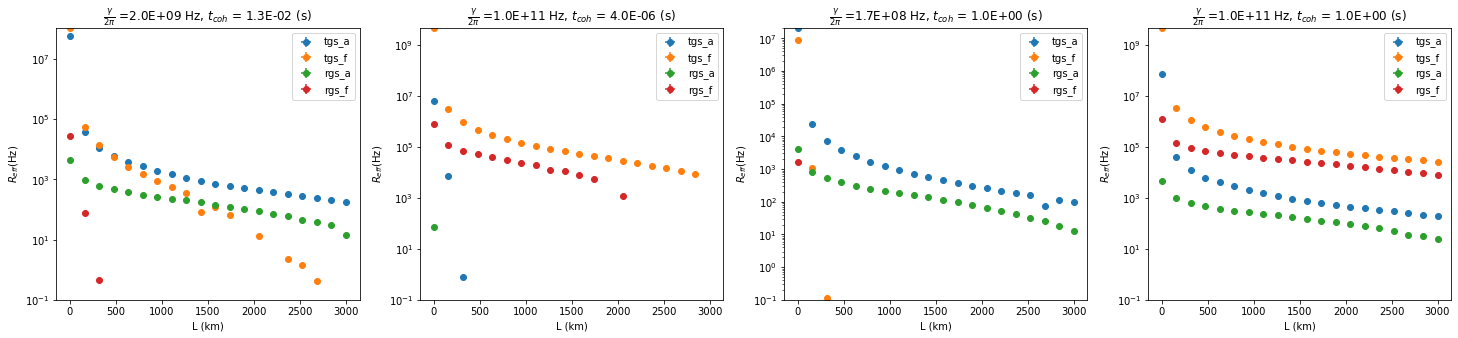

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(25,5))
fig.set_facecolor('white')
for param_in in range(4):
        ax = axs[param_in]
        max_r = 0
        for name in names:
            max_r = max(max_r, max(r))
            r = R_dict[(name, param_in)]
            ax.errorbar(L_list/1000, r, xerr=0, yerr=0, fmt='o', label=name)
            ax.set_ylim(0.1,max_r)
        ax.set_ylabel("$R_{eff}$" + "(Hz)")
        ax.set_yscale('log')
        ax.set_xlabel("L (km)")

        ax.set_title("$\\frac{\gamma}{2\pi}$ =" + f"{GAMMA[param_in]/2/np.pi :.1E} Hz, " + 
                    "$t_{coh}$ = " f"{T_SPIN_COHERENCE[param_in]:.1E} (s)")
        ax.legend()